# Time series prediction with ZZFeatureMap

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator  
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM
from qiskit.circuit import Parameter, ParameterVector
from qiskit.providers.basic_provider import BasicSimulator
from scipy.signal import argrelextrema
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

from typing import List, Callable, Union

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# To visualize circuit creation process
from qiskit.visualization import circuit_drawer
np.random.seed(42)



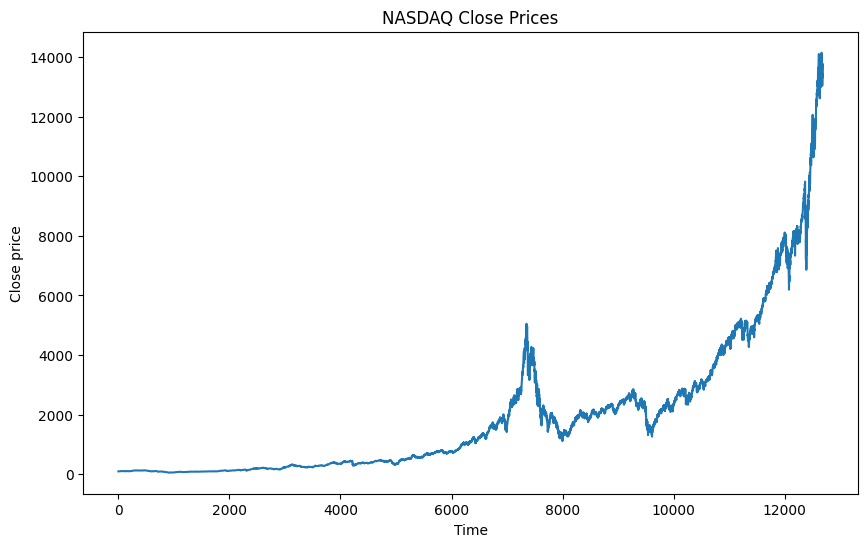

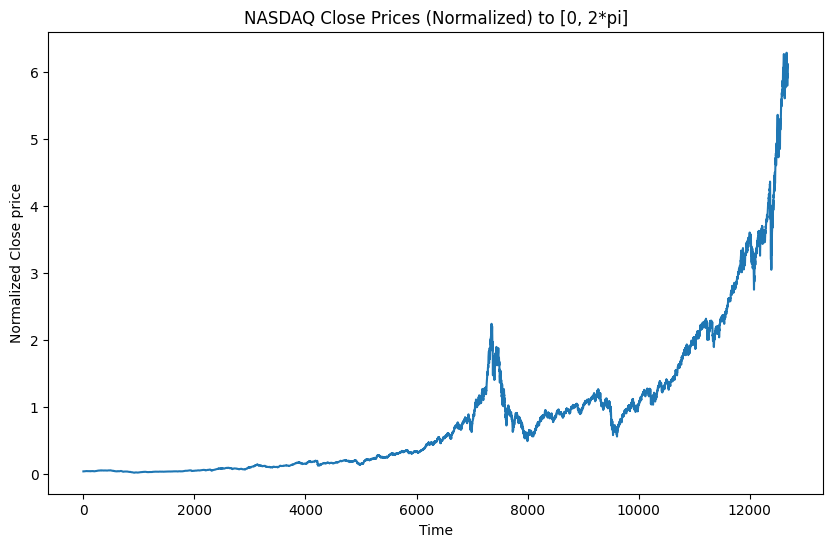

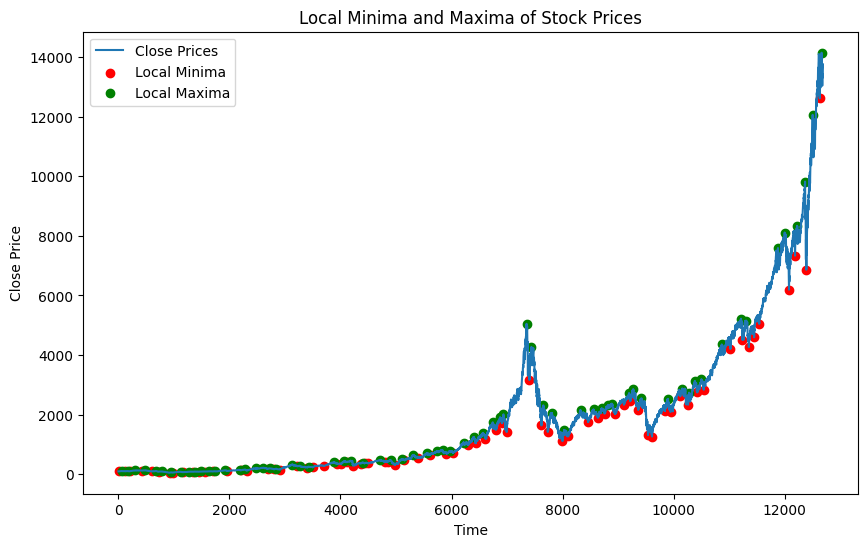

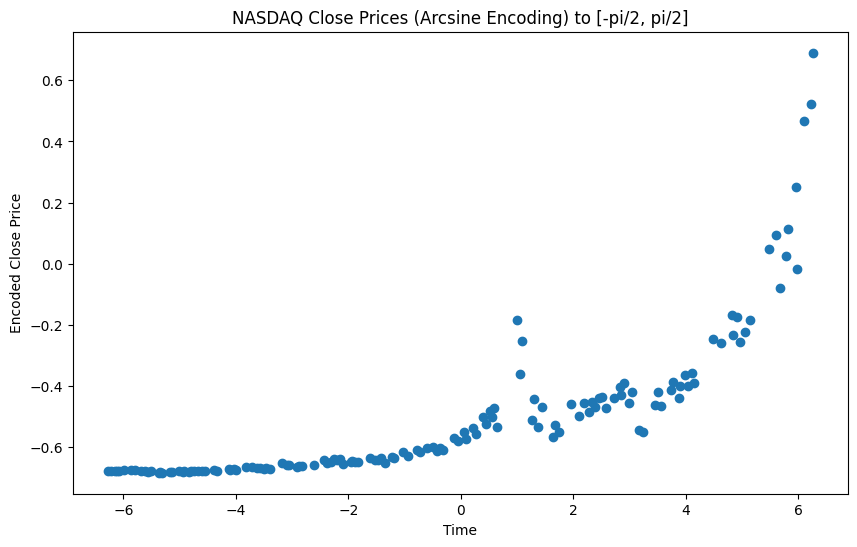

In [151]:
# load dataset
stock_data = pd.read_csv('C:/Users/lucam/OneDrive/Desktop/ZHAW/Semester_5/QI/Project/git/Quantum-Computing-Data-Repetition/src/experiments/serial_data/data/indexData.csv')  
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC']
close_prices = nasdaq_data['Close'].values  
x = np.arange(len(close_prices)) 

plt.figure(figsize=(10, 6))
plt.plot(x, close_prices)
plt.title("NASDAQ Close Prices")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()

# Normalize close prices to range [0, 2*pi]
max_close_price = max(close_prices)
y = (close_prices / max_close_price) * 2 * np.pi  # Normalize data to [0, 2*pi]

# Plot the normalized close prices
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("NASDAQ Close Prices (Normalized) to [0, 2*pi]")
plt.xlabel("Time")
plt.ylabel("Normalized Close price")
plt.show()


order = 50
local_minima = argrelextrema(close_prices, np.less, order=order)[0]
local_maxima = argrelextrema(close_prices, np.greater, order=order)[0]
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label="Close Prices")
plt.scatter(local_minima, close_prices[local_minima], marker='o', color='red', label="Local Minima")
plt.scatter(local_maxima, close_prices[local_maxima], marker='o', color='green', label="Local Maxima")
plt.title("Local Minima and Maxima of Stock Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
num_extrema = len(local_minima) + len(local_maxima)

x_points = np.concatenate((local_minima, local_maxima))
y_points = close_prices[x_points]

# Normalize the x_points to [-2*pi, 2*pi] and y to [-1, 1]
x_points = (x_points / len(close_prices)) * 4 * np.pi - 2 * np.pi
y_points = (y_points / max_close_price) * 2 - 1


def arcsine_encoding(x):
    return np.arcsin(2 * x / np.pi)
y_points = arcsine_encoding(y_points)
plt.figure(figsize=(10, 6))
plt.plot(x_points, y_points, 'o')
plt.title("NASDAQ Close Prices (Arcsine Encoding) to [-pi/2, pi/2]")
plt.xlabel("Time")
plt.ylabel("Encoded Close Price")
plt.show()

In [112]:

class ArcsineFeatureMap(QuantumCircuit):
    """A custom feature map using the arcsine function to transform a single input feature."""

    def __init__(
        self,
        feature_dimension: int = 1,
        name: str = "ArcsineFeatureMap",
    ) -> None:
        """Create a new Arcsine Feature Map circuit for a single feature.
        
        Args:
            feature_dimension: The number of features (set to 1 for a single feature map)
            name: Name of QuantumCircuit object
        """
        if feature_dimension != 1:
            raise ValueError("This feature map is designed for a single feature only.")
        
        self.feature_dimension = feature_dimension
        self.training_parameters = None

        # Call the QuantumCircuit initialization
        super().__init__(1, name=name)  # We only need one qubit for a single feature

        # Build the feature map circuit
        self._generate_feature_map()

    def _generate_feature_map(self):
        # Vector of data parameters (single feature)
        input_param = Parameter("x")  # This is the input feature

        # Apply a symbolic Ry rotation based on the input parameter
        # Instead of performing np.arcsin directly, we apply the rotation on the parameter
        self.ry(input_param, self.qubits[0])  # Apply Ry rotation with input parameter on qubit 0


# Create feature map instance for a single feature
feature_map = ArcsineFeatureMap(feature_dimension=1)

# Visualize the quantum circuit using the circuit drawer
circuit_drawer(feature_map)

┌───────┐
q: ┤ Ry(x) ├
   └───────┘

In [ ]:

x_combined = x.reshape(-1, 1)
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

regression_estimator_qnn = EstimatorQNN(circuit=qc)

regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

regressor.fit(x_combined, y)
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(x, y, "bo")
y_ = regressor.predict(x_combined)
plt.plot(x, y_, "g-")
plt.show()

regressor.score(x_combined, y)




KeyboardInterrupt: 

In [83]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)

Linear Encoding MSE: 1690.7919183623667
Arcsine Encoding MSE: 93967.57373517372


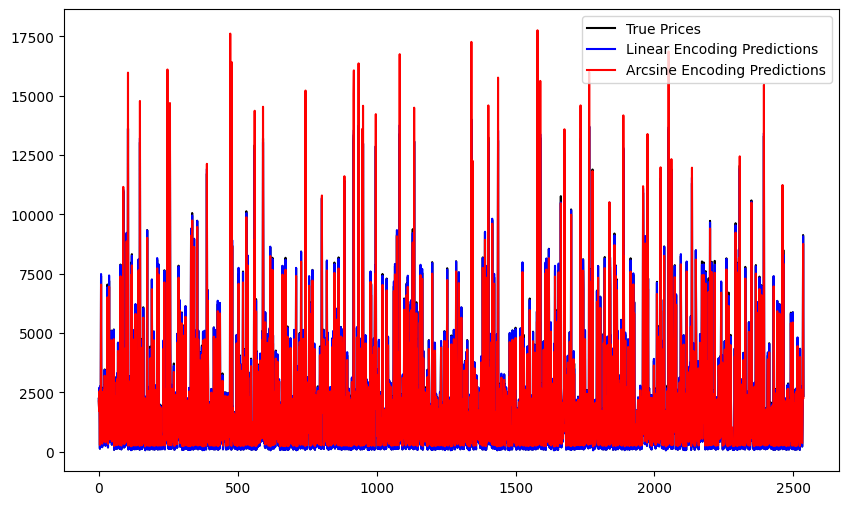

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create lagged features (e.g., previous day's price, moving averages)
def create_features(prices, window_size=5):
    X = []
    y = []
    for i in range(window_size, len(prices)):
        X.append(prices[i-window_size:i])  # Last 'window_size' prices as features
        y.append(prices[i])  # Next day's price as target
    return np.array(X), np.array(y)

X, y = create_features(close_prices)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data for arcsine encoding
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.clip(X_train_scaled, -1, 1)  # Clip values to the valid range [-1, 1]
X_test_scaled = np.clip(X_test_scaled, -1, 1)    # Clip values to the valid range [-1, 1]

# Apply arcsine encoding (arcsine of the normalized values)
X_train_arcsine = np.arcsin(X_train_scaled)
X_test_arcsine = np.arcsin(X_test_scaled)

# Linear Encoding Model (using raw features)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Arcsine Encoding Model
arcsine_model = LinearRegression()
arcsine_model.fit(X_train_arcsine, y_train)
y_pred_arcsine = arcsine_model.predict(X_test_arcsine)

# Evaluate the models (use MSE or R-squared as metrics)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_arcsine = mean_squared_error(y_test, y_pred_arcsine)

print(f"Linear Encoding MSE: {mse_linear}")
print(f"Arcsine Encoding MSE: {mse_arcsine}")

# Plot results for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Prices", color='black')
plt.plot(y_pred_linear, label="Linear Encoding Predictions", color='blue')
plt.plot(y_pred_arcsine, label="Arcsine Encoding Predictions", color='red')
plt.legend()
plt.show()

In [84]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
)

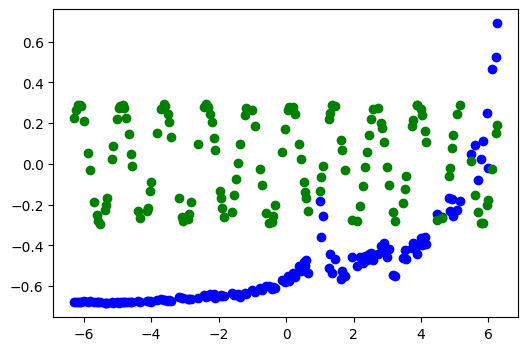

-5.310465523400507

In [158]:

x_points = x_points.reshape(-1, 1)
repetitions = 5

param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
for _ in range(repetitions):  # Repeat the feature map multiple times
    feature_map.ry(param_x, 0)


param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
for _ in range(repetitions):  # Repeat the ansatz multiple times
    ansatz.rx(param_y, 0)
    ansatz.ry(param_y, 0)
    ansatz.rz(param_y, 0)

qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

regression_estimator_qnn = EstimatorQNN(circuit=qc)

regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# fit to data
regressor.fit(x_points, y_points)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# plot data
plt.plot(x_points, y_points, "bo")

# plot fitted line
y_ = regressor.predict(x_points)
plt.plot(x_points, y_, "go")
plt.show()

# score the result
regressor.score(x_points, y_points)

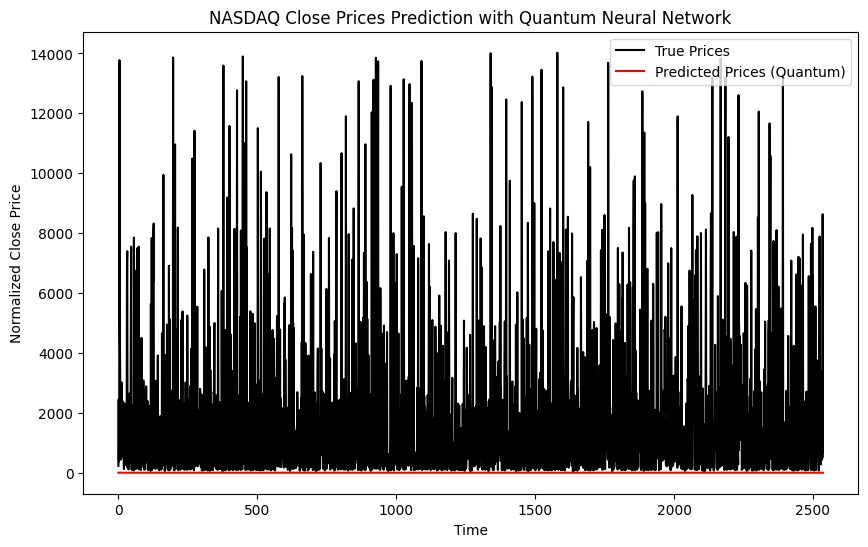

Mean Squared Error (MSE): 10096388.753189605


In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
num_qubits = 4

# Load dataset
stock_data = pd.read_csv('C:/Users/lucam/OneDrive/Desktop/ZHAW/Semester_5/QI/Project/git/Quantum-Computing-Data-Repetition/src/experiments/serial_data/data/indexData.csv')
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC'].copy()
nasdaq_data['Price Change'] = nasdaq_data['Close'].diff() 
nasdaq_data['5-day MA'] = nasdaq_data['Close'].rolling(window=5).mean()
nasdaq_data['High-Low Range'] = nasdaq_data['High'] - nasdaq_data['Low']
nasdaq_data = nasdaq_data.dropna()

# Create lagged features for better prediction (e.g., previous day's price)
# Modify create_lagged_features to use only two features
def create_lagged_features(data, window_size=5):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Use only two features: last 'window_size' close prices and price change
        features = [
            data.iloc[i - 1]['Close'],
            data.iloc[i - 1]['Price Change'],
            data.iloc[i - 1]['5-day MA'],
            data.iloc[i - 1]['High-Low Range']
        ]
        
        X.append(features)  # Append the two features
        y.append(data.iloc[i]['Close'])  # Next day's closing price
        
    return np.array(X), np.array(y)

# Create features and labels
X, y = create_lagged_features(nasdaq_data)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data for QNN (scaling to [0, 2*pi] range)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the quantum neural network
param_x = [Parameter(f"x{i}") for i in range(num_qubits)]
param_y = [Parameter(f"y{i}") for i in range(num_qubits)]

feature_map = QuantumCircuit(num_qubits, name="fm")
for i, p in enumerate(param_x):
    feature_map.ry(p, i)

ansatz = QuantumCircuit(num_qubits, name="vf")
for i, p in enumerate(param_y):
    ansatz.ry(p, i)

qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# Setup Quantum Neural Network (QNN)
regression_estimator_qnn = EstimatorQNN(circuit=qc)

# Create regressor model
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
)

# Fit the regressor model
regressor.fit(X_train_scaled, y_train)

# Predict using the trained model
y_pred = regressor.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Prices", color='black')
plt.plot(y_pred, label="Predicted Prices (Quantum)", color='red')
plt.title("NASDAQ Close Prices Prediction with Quantum Neural Network")
plt.xlabel("Time")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
num_qubits = 33  # As you have 33 features

# Load dataset
stock_data = pd.read_csv('C:/Users/lucam/OneDrive/Desktop/ZHAW/Semester_5/QI/Project/git/Quantum-Computing-Data-Repetition/src/experiments/serial_data/data/indexData.csv')
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC'].copy()  # Create a copy to avoid warning

# Calculate additional features (Price Change, Moving Averages)
nasdaq_data.loc[:, 'Price Change'] = nasdaq_data['Close'].diff()  # Price change (daily)
nasdaq_data.loc[:, '5-day MA'] = nasdaq_data['Close'].rolling(window=5).mean()  # 5-day moving average
nasdaq_data.loc[:, '10-day MA'] = nasdaq_data['Close'].rolling(window=10).mean()  # 10-day moving average
nasdaq_data.loc[:, '20-day MA'] = nasdaq_data['Close'].rolling(window=20).mean()  # 20-day moving average

# Drop rows with NaN values (due to diff or rolling operations)
nasdaq_data = nasdaq_data.dropna()

# Create lagged features for better prediction (e.g., previous day's price)
def create_lagged_features(data, window_size=5):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Use iloc to safely index rows by position
        features = []
        
        # Last 'window_size' close prices
        features.append(np.array(data.iloc[i-window_size:i]['Close'].values))  
        
        # Last 'window_size' open prices
        features.append(np.array(data.iloc[i-window_size:i]['Open'].values))   
        
        # Last 'window_size' high prices
        features.append(np.array(data.iloc[i-window_size:i]['High'].values))   
        
        # Last 'window_size' low prices
        features.append(np.array(data.iloc[i-window_size:i]['Low'].values))    
        
        # Last 'window_size' volume data
        features.append(np.array(data.iloc[i-window_size:i]['Volume'].values)) 
        
        # Price change over the last 'window_size' days
        features.append(np.array(data.iloc[i-window_size:i]['Price Change'].values))  
        
        # Current moving averages
        features.append(np.array([data.iloc[i]['5-day MA']]))  
        features.append(np.array([data.iloc[i]['10-day MA']])) 
        features.append(np.array([data.iloc[i]['20-day MA']]))
        
        # Ensure that all arrays have the same dimensions before concatenating
        features = np.concatenate([f.reshape(-1) for f in features])
        
        X.append(features)  # Append the concatenated features
        y.append(data.iloc[i]['Close'])  # Next day's closing price
        
    return np.array(X), np.array(y)

# Create features and labels
X, y = create_lagged_features(nasdaq_data)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data for QNN (scaling to [0, 2*pi] range)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_x = Parameter("x")
param_y = Parameter("y")

feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
# Setup Quantum Neural Network (QNN)
regression_estimator_qnn = EstimatorQNN(circuit=qc)

# Create regressor model
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
)

# Fit the regressor model
regressor.fit(X_train_scaled, y_train)

# Predict using the trained model
y_pred = regressor.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Prices", color='black')
plt.plot(y_pred, label="Predicted Prices (Quantum)", color='red')
plt.title("NASDAQ Close Prices Prediction with Quantum Neural Network")
plt.xlabel("Time")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()

# Evaluate the model performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


QiskitMachineLearningError: 'Input data has incorrect shape, last dimension is not equal to the number of inputs: 1, but got: 33.'

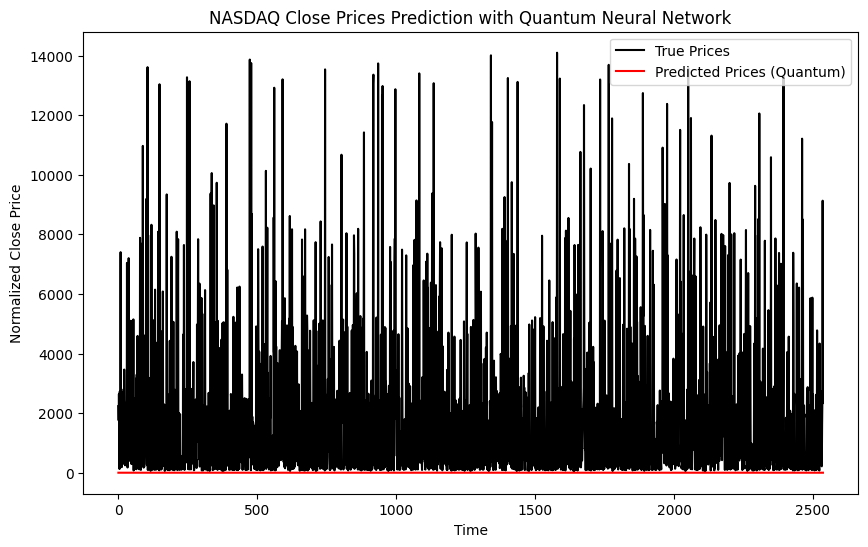

Mean Squared Error (MSE): 9703272.288786918


In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
num_qubits = 1

# Load dataset
stock_data = pd.read_csv('C:/Users/lucam/OneDrive/Desktop/ZHAW/Semester_5/QI/Project/git/Quantum-Computing-Data-Repetition/src/experiments/serial_data/data/indexData.csv')
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC'].copy()

# Create lagged features for better prediction (e.g., previous day's price)
# Modify create_lagged_features to use only two features
def create_lagged_features(data, window_size=5):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Use only two features: last 'window_size' close prices and price change
        features = [
            data.iloc[i - 1]['Close']
        ]
        X.append(features)  # Append the two features
        y.append(data.iloc[i]['Close'])  # Next day's closing price
        
    return np.array(X), np.array(y)

# Create features and labels
X, y = create_lagged_features(nasdaq_data)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data for QNN (scaling to [0, 2*pi] range)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the quantum neural network
param_x = [Parameter(f"x{i}") for i in range(num_qubits)]
param_y = [Parameter(f"y{i}") for i in range(num_qubits)]

feature_map = QuantumCircuit(num_qubits, name="fm")
for i, p in enumerate(param_x):
    feature_map.ry(p, i)

ansatz = QuantumCircuit(num_qubits, name="vf")
for i, p in enumerate(param_y):
    ansatz.ry(p, i)

qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# Setup Quantum Neural Network (QNN)
regression_estimator_qnn = EstimatorQNN(circuit=qc)

# Create regressor model
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
)

# Fit the regressor model
regressor.fit(X_train_scaled, y_train)

# Predict using the trained model
y_pred = regressor.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Prices", color='black')
plt.plot(y_pred, label="Predicted Prices (Quantum)", color='red')
plt.title("NASDAQ Close Prices Prediction with Quantum Neural Network")
plt.xlabel("Time")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

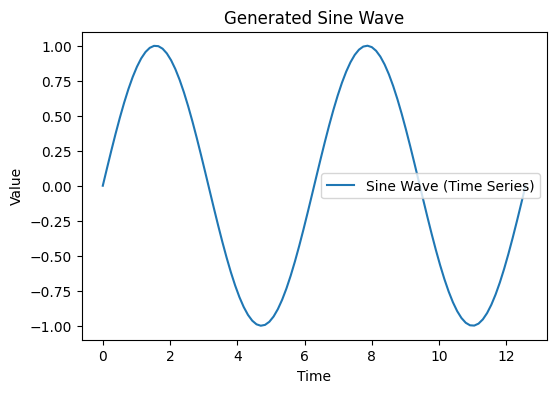

C:\Users\lucam\AppData\Local\Temp\ipykernel_22100\853928072.py:74: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  initial_params = np.random.rand(len(quantum_circuit[1]))  # Random initial parameters
C:\Users\lucam\AppData\Local\Temp\ipykernel_22100\853928072.py:50: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  parameter_dict = {quantum_circuit[1][i]: params[i] for i in range(len(params))}


TypeError: unhashable type: 'RXGate'

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator  # Correct import for AerSimulator
from scipy.optimize import minimize
from qiskit.circuit import Parameter

# Step 1: Generate a Simple Time-Series Dataset (Sine Wave)
def generate_sine_wave(num_points=100):
    x = np.linspace(0, 4 * np.pi, num_points)  # Time points
    y = np.sin(x)  # Sine wave as the target time series
    return x, y

# Generate the dataset
x_data, y_data = generate_sine_wave(100)

# Plot the dataset
plt.plot(x_data, y_data, label="Sine Wave (Time Series)")
plt.title("Generated Sine Wave")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# Step 2: Define a Quantum Circuit for Regression
def create_quantum_circuit():
    # Define the number of qubits (3 qubits)
    qc = QuantumCircuit(3)
    
    # Define parameters (angles) that will be optimized
    theta1 = Parameter('θ1')
    theta2 = Parameter('θ2')
    theta3 = Parameter('θ3')
    
    # Apply gates to the qubits (create a simple parameterized quantum circuit)
    qc.h(0)  # Apply Hadamard gate to the first qubit
    qc.rx(theta1, 1)  # Apply RX rotation to the second qubit
    qc.rx(theta2, 2)  # Apply RX rotation to the third qubit
    qc.cx(0, 1)  # Apply CNOT gate (control qubit 0, target qubit 1)
    qc.cx(1, 2)  # Apply CNOT gate (control qubit 1, target qubit 2)
    
    # Measure the qubits
    qc.measure_all()
    
    return qc, [theta1, theta2, theta3]

# Step 3: Define a Cost Function for the Quantum Circuit (MSE)
def cost_function(params, quantum_circuit, simulator, x_data, y_data):
    # Bind the parameters to the quantum circuit using the parameter dictionary
    parameter_dict = {quantum_circuit[1][i]: params[i] for i in range(len(params))}
    bound_circuit = quantum_circuit[0].bind_parameters(parameter_dict)
    
    # Simulate the circuit
    job = simulator.run(bound_circuit, shots=1)
    result = job.result()
    
    # Get the outcome (measurement result)
    counts = result.get_counts()
    outcome = list(counts.keys())[0]
    
    # Convert the outcome to a value (scaled down for 3 qubits)
    predicted_value = int(outcome, 2) / 8
    
    # Compute the MSE between the predicted value and true value
    mse = np.mean((predicted_value - y_data) ** 2)
    return mse

# Step 4: Optimize the Quantum Circuit Parameters Using Scipy
def train_quantum_circuit(x_data, y_data, quantum_circuit):
    # Create the simulator
    simulator = AerSimulator()  # Use AerSimulator from qiskit_aer
    
    # Initial random parameters for the quantum circuit
    initial_params = np.random.rand(len(quantum_circuit[1]))  # Random initial parameters
    
    # Minimize the cost function (MSE)
    result = minimize(cost_function, initial_params, args=(quantum_circuit, simulator, x_data, y_data), method='COBYLA')
    
    return result

# Step 5: Forecast Future Values Using the Optimized Parameters
def forecast_future_values(quantum_circuit, optimized_params, future_points=10):
    forecast = []
    
    # Create the simulator
    simulator = AerSimulator()  # Use AerSimulator from qiskit_aer
    
    for _ in range(future_points):
        # Bind the optimized parameters to the circuit
        parameter_dict = {quantum_circuit[1][i]: optimized_params[i] for i in range(len(optimized_params))}
        circuit = quantum_circuit[0].bind_parameters(parameter_dict)
        
        # Simulate the circuit and get the predicted value
        job = simulator.run(circuit, shots=1)
        result = job.result()
        counts = result.get_counts()
        outcome = list(counts.keys())[0]
        
        # Convert the outcome to a value
        predicted_value = int(outcome, 2) / 8  # Scale the value to match the range
        
        forecast.append(predicted_value)
    
    return forecast

# Step 6: Train the Quantum Circuit and Forecast Future Values
quantum_circuit, params = create_quantum_circuit()
result = train_quantum_circuit(x_data, y_data, quantum_circuit)

# Print the optimized parameters
print("Optimized Parameters:", result.x)

# Step 7: Forecast the Next 10 Points (Future Time-Series Values)
forecasted_values = forecast_future_values(quantum_circuit, result.x, future_points=10)

# Plot the original time series and forecasted values
plt.plot(x_data, y_data, label="Original Time Series")
plt.plot(np.arange(len(x_data), len(x_data) + 10), forecasted_values, label="Forecasted Values", linestyle='--')
plt.legend()
plt.title("Quantum Time-Series Forecasting")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


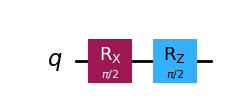

In [200]:

# Define your custom feature map
def custom_feature_map(x):
    """
    A simple feature map using rotations (RX and RZ) gates based on the input x.
    This can be extended for more complex feature maps.
    """
    # Create a quantum circuit with 1 qubit
    qc = QuantumCircuit(1)

    # Define parameters (the data x will influence these angles)
    theta1 = Parameter('θ1')
    theta2 = Parameter('θ2')
    
    # Encode the data using rotations
    qc.rx(theta1, 0)  # Rotation along X-axis
    qc.rz(theta2, 0)  # Rotation along Z-axis
    
    # You can also add other gates if needed, for example, a CNOT or a series of rotations
    return qc.assign_parameters({theta1: x, theta2: x})

# Example usage
x = np.pi / 2  # Sample input data
feature_map_circuit = custom_feature_map(x)

# Draw the circuit
feature_map_circuit.draw('mpl')

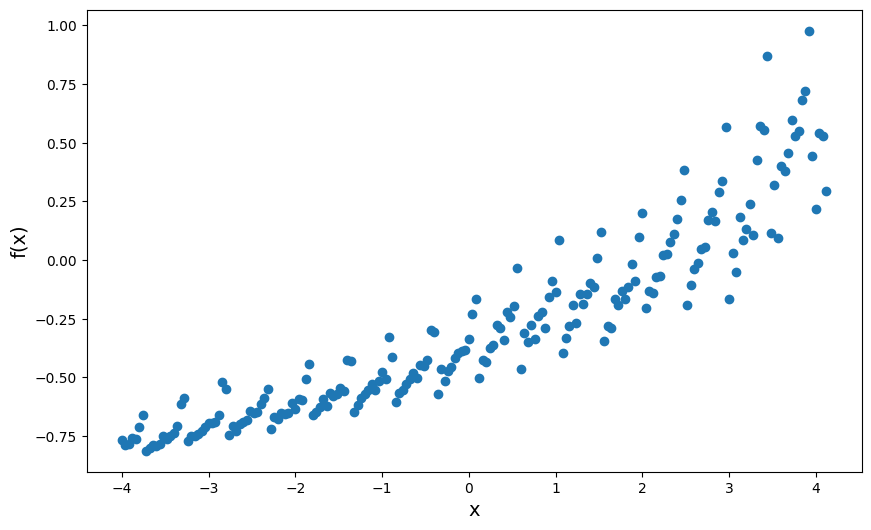

TypeError: issubclass() arg 1 must be a class

In [214]:
from functools import partial

# Load the time series data
url = 'https://raw.githubusercontent.com/selva86/datasets/master/a10.csv'
df = pd.read_csv(url, parse_dates=['date'])

# Prepare features (X) and labels (Y) for the time series data
X = (df.index - 100) / 25  # Scaled feature values
Y = df.value / 15 - 1  # Scaled target values

# Plot the noisy data
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Noisy Data')
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14)
plt.show()

# Define the custom quantum circuit with one qubit
def create_quantum_circuit(var):
    # Create a quantum register and classical register
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    # Define parameters for encoding (e.g., rotations around Y axis)
    theta1 = Parameter('θ1')
    theta2 = Parameter('θ2')
    theta3 = Parameter('θ3')

    # Use RX, RY, and RZ rotations to encode features into the quantum state
    circuit.append([circuit.ry(theta1, q[0]),
                    circuit.ry(theta2, q[0]),
                    circuit.ry(theta3, q[0])], [q[0]])

    # Use EfficientSU2 for the variational quantum circuit (VQC)
    ansatz = EfficientSU2(1, reps=3)
    circuit.append(ansatz, [q[0]])

    # Bind the parameters to the circuit
    param_dict = {theta1: var[0], theta2: var[1], theta3: var[2]}
    circuit = circuit.assign_parameters(param_dict)

    # Measurement
    circuit.measure(q[0], c[0])
    
    return circuit

# Initialize the optimizer (COBYLA)
optimizer = COBYLA(maxiter=500, disp=True)

# Function to simulate the quantum circuit and return the result
def run_simulation(circuit):
    # Setup the backend simulator
    backend = BasicSimulator()
    job = backend.run(circuit)
    result = job.result()
    counts = result.get_counts()
    return counts.get('1', 0) / 1024  # Return the normalized result

# Cost function for regression (Mean Squared Error)
def cost(var, features, labels):
    # Create the quantum circuit with the current parameters
    circuit = create_quantum_circuit(var)
    
    # Run the simulation and get the result
    preds = [run_simulation(create_quantum_circuit(var)) for x in features]
    
    # Calculate the Mean Squared Error (MSE)
    loss = np.mean((np.array(labels) - np.array(preds))**2)
    return loss

# Ensure correct initial parameters for optimization
num_params = 3  # Number of parameters in the quantum circuit
var_init = 0.05 * np.random.randn(num_params)

# Create a partial function for the cost function with fixed X and Y
cost_function = partial(cost, features=X, labels=Y)

# Training the model using the optimizer
result = optimizer.minimize(cost_function, x0=var_init)

# Extract the optimized parameters
var_opt = result.x

# Predictions from the trained quantum neural network
x_pred = np.linspace(-1, 3, 50)
predictions = [run_simulation(create_quantum_circuit(var_opt)) for x in x_pred]

# Plot the fitted data
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Noisy Data')
plt.plot(x_pred, predictions, color="red", label='Fitted Quantum Model')
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14)
plt.legend()
plt.show()

# Extended prediction range
x_pred_extended = np.linspace(-3, 4, 50)
predictions_extended = [run_simulation(create_quantum_circuit(var_opt)) for x in x_pred_extended]

# Plot the extended prediction
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Noisy Data')
plt.plot(x_pred_extended, predictions_extended, color="red", label='Extended Prediction')
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14)
plt.legend()
plt.show()

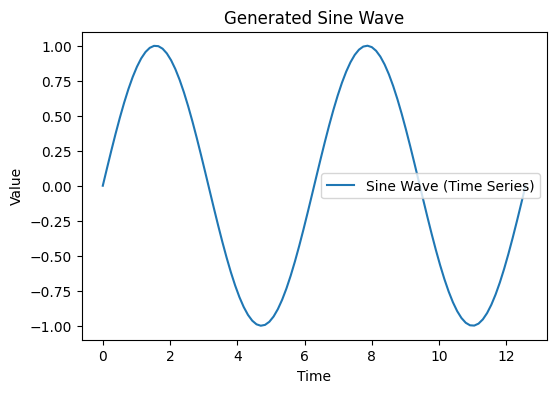

C:\Users\lucam\AppData\Local\Temp\ipykernel_22100\2709512926.py:74: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  initial_params = np.random.rand(len(quantum_circuit[1]))  # Random initial parameters


AttributeError: 'qiskit._accelerate.circuit.CircuitInstruction' object has no attribute 'parameters'

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator  # Correct import for AerSimulator
from scipy.optimize import minimize
from qiskit.circuit import Parameter

# Step 1: Generate a Simple Time-Series Dataset (Sine Wave)
def generate_sine_wave(num_points=100):
    x = np.linspace(0, 4 * np.pi, num_points)  # Time points
    y = np.sin(x)  # Sine wave as the target time series
    return x, y

# Generate the dataset
x_data, y_data = generate_sine_wave(100)

# Plot the dataset
plt.plot(x_data, y_data, label="Sine Wave (Time Series)")
plt.title("Generated Sine Wave")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# Step 2: Define a Quantum Circuit for Regression
def create_quantum_circuit():
    # Define the number of qubits (3 qubits)
    qc = QuantumCircuit(3)
    
    # Define parameters (angles) that will be optimized
    theta1 = Parameter('θ1')
    theta2 = Parameter('θ2')
    theta3 = Parameter('θ3')
    
    # Apply gates to the qubits (create a simple parameterized quantum circuit)
    qc.h(0)  # Apply Hadamard gate to the first qubit
    qc.rx(theta1, 1)  # Apply RX rotation to the second qubit
    qc.rx(theta2, 2)  # Apply RX rotation to the third qubit
    qc.cx(0, 1)  # Apply CNOT gate (control qubit 0, target qubit 1)
    qc.cx(1, 2)  # Apply CNOT gate (control qubit 1, target qubit 2)
    
    # Measure the qubits
    qc.measure_all()
    
    return qc, [theta1, theta2, theta3]

# Step 3: Define a Cost Function for the Quantum Circuit (MSE)
def cost_function(params, quantum_circuit, simulator, x_data, y_data):
    # Bind the parameters to the quantum circuit
    parameter_dict = {quantum_circuit.parameters[i]: params[i] for i in range(len(params))}
    bound_circuit = quantum_circuit.bind_parameters(parameter_dict)
    
    # Simulate the circuit
    job = simulator.run(bound_circuit, shots=1)
    result = job.result()
    
    # Get the outcome (measurement result)
    counts = result.get_counts()
    outcome = list(counts.keys())[0]
    
    # Convert the outcome to a value (scaled down for 3 qubits)
    predicted_value = int(outcome, 2) / 8
    
    # Compute the MSE between the predicted value and true value
    mse = np.mean((predicted_value - y_data) ** 2)
    return mse

# Step 4: Optimize the Quantum Circuit Parameters Using Scipy
def train_quantum_circuit(x_data, y_data, quantum_circuit):
    # Create the simulator
    simulator = AerSimulator()  # Use AerSimulator from qiskit_aer
    
    # Initial random parameters for the quantum circuit
    initial_params = np.random.rand(len(quantum_circuit[1]))  # Random initial parameters
    
    # Minimize the cost function (MSE)
    result = minimize(cost_function, initial_params, args=(quantum_circuit[0], simulator, x_data, y_data), method='COBYLA')
    
    return result

# Step 5: Forecast Future Values Using the Optimized Parameters
def forecast_future_values(quantum_circuit, optimized_params, future_points=10):
    forecast = []
    
    # Create the simulator
    simulator = AerSimulator()  # Use AerSimulator from qiskit_aer
    
    for _ in range(future_points):
        # Bind the optimized parameters to the circuit
        parameter_dict = {quantum_circuit[0].parameters[i]: optimized_params[i] for i in range(len(optimized_params))}
        circuit = quantum_circuit[0].bind_parameters(parameter_dict)
        
        # Simulate the circuit and get the predicted value
        job = simulator.run(circuit, shots=1)
        result = job.result()
        counts = result.get_counts()
        outcome = list(counts.keys())[0]
        
        # Convert the outcome to a value
        predicted_value = int(outcome, 2) / 8  # Scale the value to match the range
        
        forecast.append(predicted_value)
    
    return forecast

# Step 6: Train the Quantum Circuit and Forecast Future Values
quantum_circuit, params = create_quantum_circuit()
result = train_quantum_circuit(x_data, y_data, quantum_circuit)

# Print the optimized parameters
print("Optimized Parameters:", result.x)

# Step 7: Forecast the Next 10 Points (Future Time-Series Values)
forecasted_values = forecast_future_values(quantum_circuit, result.x, future_points=10)

# Plot the original time series and forecasted values
plt.plot(x_data, y_data, label="Original Time Series")
plt.plot(np.arange(len(x_data), len(x_data) + 10), forecasted_values, label="Forecasted Values", linestyle='--')
plt.legend()
plt.title("Quantum Time-Series Forecasting")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

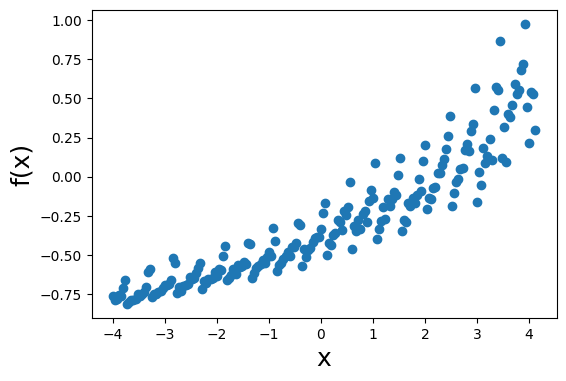

In [227]:

# Random seed for reproducibility
np.random.seed(42)

# Data Preparation: Loading and scaling the time series
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
X = (df.index - 100) / 25  # Normalize X
Y = df['value'] / 15 - 1   # Normalize Y

# Visualize the original time series data
plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.show()




In [229]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

def layer(v):
    # Ensure that the input is a numpy array or list of numeric values
    v = np.array(v, dtype=float)

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)
    
    # Matrix multiplication of input layer (Rotations and Squeezing)
    # Apply rotations (using RZ and RX gates)
    qc.rz(v[0], 0)  # Equivalent to qml.Rotation (rotation around Z axis)
    qc.rx(v[1], 0)  # A single-qubit rotation for squeezing (approximation)
    qc.rx(v[2], 0)  # Another rotation on qubit 0
    
    # Bias (Displacement), using a phase shift as a substitute
    qc.p(v[3], 0)  # Phase shift to simulate displacement

    # Element-wise nonlinear transformation (Kerr effect)
    # Using RX gate as a simple substitute for the Kerr effect
    qc.rx(v[4], 0)  # Using RX to simulate the Kerr transformation

    return qc

# Example usage:
v = np.random.rand(5)  # Example input values (random values between 0 and 1)
qc = layer(v)
print(qc.draw())


   ┌─────────────┐┌──────────────┐┌─────────────┐┌────────────┐┌─────────────┐
q: ┤ Rz(0.15599) ├┤ Rx(0.058084) ├┤ Rx(0.86618) ├┤ P(0.60112) ├┤ Rx(0.70807) ├
   └─────────────┘└──────────────┘└─────────────┘└────────────┘└─────────────┘


In [244]:
def layer(v, qc):
    # Apply rotations and other gates to simulate the 'layer' function
    qc.rz(v[0], 0)  # Equivalent to qml.Rotation (rotation around Z axis)
    qc.rx(v[1], 0)  # Squeezing approximation (single-qubit rotation)
    qc.rx(v[2], 0)  # Another rotation on qubit 0
    qc.p(v[3], 0)   # Phase shift (Displacement)
    qc.rx(v[4], 0)  # Nonlinear transformation (Kerr effect approximation)
    return qc

def quantum_neural_net(var, x=None):
    # Create quantum circuit with 1 qubit
    qc = QuantumCircuit(1, 1)

    # Encode input x into quantum state (Displacement or Phase Shift)
    if x is not None:
        qc.p(x, 0)  # Using phase shift as a simple displacement

    # Apply layers
    for v in var:
        qc = layer(v, qc)

    # Measure the expectation value of Pauli-X operator
    qc.measure(0, 0)
    
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile (qc, simulator)
    sim_result = simulator.run(compiled_circuit).result()

    counts = sim_result.get_counts()
    
    # Return the expectation value (estimated from the counts)
    expval = (counts.get('0', 0) - counts.get('1', 0)) / 1024  # Difference in counts for '0' and '1'
    return expval
from qiskit import transpile
var = np.random.rand(5, 5)  # Example input variables (random values for layer parameters)
x = np.random.rand()  # Example input to encode
expval = quantum_neural_net(var, x)
print(f"Expectation value: {expval}")

Expectation value: 0.498046875


In [245]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

In [246]:
np.random.seed(0)
num_layers = 6
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]
 [-0.12764949  0.03268093  0.04322181 -0.03710825  0.11348773]
 [-0.07271828  0.00228793 -0.00935919  0.07663896  0.07346794]]


In [ ]:
# Define the square loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# Define the cost function for optimization
def cost(var, features, labels):
    # Flatten var to match expected shape for the optimizer
    var_flat = var.reshape(-1, 5)  # Flatten to (num_layers, 5)
    preds = [quantum_neural_net(var_flat, x=x) for x in features]
    return square_loss(labels, preds)

# Quantum neural network function
def quantum_neural_net(var, x=None):
    qc = QuantumCircuit(1, 1)

    if x is not None:
        qc.p(x, 0)  # Using phase shift as a simple displacement

    for v in var:
        qc = layer(v, qc)

    qc.measure(0, 0)

    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(qc, simulator)
    sim_result = simulator.run(compiled_circuit).result()

    counts = sim_result.get_counts()
    expval = (counts.get('0', 0) - counts.get('1', 0)) / 1024  # Difference in counts for '0' and '1'
    return expval

# Define the layer function
def layer(v, qc):
    qc.rz(v[0], 0)
    qc.rx(v[1], 0)
    qc.rx(v[2], 0)
    qc.p(v[3], 0)
    qc.rx(v[4], 0)
    return qc

# Define the optimization function using Qiskit's ADAM
def optimize_with_adam(var_init, features, labels, learning_rate=0.001, epochs=100):
    # Flatten the initial variables to make them 1D
    var_init_flat = var_init.flatten()

    # Initialize the ADAM optimizer from Qiskit
    adam_optimizer = ADAM(maxiter=epochs, lr=learning_rate)

    # Cost function for optimization
    def cost_function(var):
        return cost(var, features, labels)

    # Use the optimizer to minimize the cost function
    result = adam_optimizer.minimize(lambda w: cost_function(w), var_init_flat)

    # Return the optimized parameters reshaped back to their original dimensions
    return result

# Data preparation (same as before)
# Split the dataset into features (X) and labels (Y)
X = (df.index - 100) / 25  # Normalize X
Y = df['value'] / 15 - 1  # Normalize Y

# Define the initial random variables
np.random.seed(0)
num_layers = 6
var_init = 0.05 * np.random.randn(num_layers, 5)

# Perform training (optimization) using Adam optimizer
result = optimize_with_adam(var_init, X, Y, learning_rate=0.001, epochs=100)

# Final trained parameters
optimized_params = result[0].reshape(num_layers, 5)
print("Trained parameters: ", optimized_params)
